In [1]:
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from matplotlib import pylab as plt
%matplotlib inline

import gym
from collections import deque
import numpy as np

from dataclasses import dataclass
from typing import Any
from random import sample, random

import cv2
import numpy as np
import gym
import time
from random import randint

# %conda install -c conda-forge wandb
import wandb

# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device

In [2]:
# env = gym.make("Breakout-v0", render_mode='human')
# obs = env.reset()
# for _ in range(1000):
#     # env.render()
#     # time.sleep(0.1)
#     action = env.action_space.sample()
#     #env.action_space.n to get number of actions
#     #env.action_space.shape to get shape of obs
#     obs , reward, done, info = env.step(action)

#     if done:
#         obs = env.reset()
# env.close()

In [3]:
@dataclass
class Sarsd:
    state: Any
    action: int
    reward: float
    next_state: Any
    done: bool

DNQ

In [4]:
class Model(nn.Module):
    def __init__(self, obs_shape, num_actions, lr=0.001):
        super(Model, self).__init__()
        assert len(obs_shape) == 1, "This network only works for flat observations"
        self.obs_shape = obs_shape
        self.num_actions = num_actions
        self.net = torch.nn.Sequential(
            torch.nn.Linear(obs_shape[0], 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, num_actions),
        )
        self.opt = optim.Adam(self.net.parameters(), lr=lr)

    def forward(self, x):
        return self.net(x)
    
class ConvModel(nn.Module):
    def __init__(self, obs_shape, num_actions, lr=0.0001):
        assert len(obs_shape) == 3  # channel, height, and width
        super(ConvModel, self).__init__()
        self.obs_shape = obs_shape
        self.num_actions = num_actions
        # canonical input shape = 84x84
        self.conv_net = torch.nn.Sequential(
            torch.nn.Conv2d(4, 16, (8, 8), stride=(4, 4)),
            torch.nn.ReLU(),
            torch.nn.Conv2d(16, 32, (4, 4), stride=(2, 2)),
            torch.nn.ReLU(),
        )

        with torch.no_grad():
            dummy = torch.zeros((1, *obs_shape))
            x = self.conv_net(dummy)
            s = x.shape
            fc_size = s[1] * s[2] * s[3]

        self.fc_net = torch.nn.Sequential(
            torch.nn.Linear(fc_size, 256),
            torch.nn.ReLU(),
            torch.nn.Linear(256, num_actions),
        )
        self.opt = optim.Adam(self.parameters(), lr=lr)

    def forward(self, x):
        conv_latent = self.conv_net(x/255.0)  # shape: (N, )
        return self.fc_net(conv_latent.view((conv_latent.shape[0], -1)))

Agent

In [5]:
class ReplayBuffer:
    def __init__(self, buffer_size=100000):
        self.buffer_size = buffer_size
        self.buffer = [None] * buffer_size
        self.idx = 0

    def insert(self, sars):
        self.buffer[self.idx % self.buffer_size] = sars
        self.idx += 1

    def sample(self, num_samples):
        assert num_samples < min(self.idx, self.buffer_size)
        # if num_samples > min(self.idx, self.buffer_size):
        if self.idx < self.buffer_size:
            return sample(self.buffer[: self.idx], num_samples)
        return sample(self.buffer, num_samples)
# class ReplayBuffer:
#     def __init__(self, buffer_size=100000):
#         self.buffer_size = buffer_size
#         self.buffer = deque(maxlen=buffer_size)

#     def insert(self, sars):
#         self.buffer.append(sars)

#     def sample(self, num_samples):
#         assert num_samples < len(self.buffer)
#         return sample(self.buffer, num_samples)

def update_tgt_model(m, tgt):
    tgt.load_state_dict(m.state_dict())


def train_step(model, state_transitions, tgt, num_actions, device, gamma=0.99):
    cur_states = torch.stack(([torch.Tensor(s.state) for s in state_transitions])).to(
        device
    )
    rewards = torch.stack(([torch.Tensor([s.reward]) for s in state_transitions])).to(
        device
    )
    mask = torch.stack(
        (
            [
                torch.Tensor([0]) if s.done else torch.Tensor([1])
                for s in state_transitions
            ]
        )
    ).to(device)
    next_states = torch.stack(
        ([torch.Tensor(s.next_state) for s in state_transitions])
    ).to(device)
    actions = [s.action for s in state_transitions]

    with torch.no_grad():
        qvals_next = tgt(next_states).max(-1)[0]  # (N, num_actions)

    model.opt.zero_grad()
    qvals = model(cur_states)  # (N, num_actions)
    one_hot_actions = F.one_hot(torch.LongTensor(actions), num_actions).to(device)

    loss_fn = nn.SmoothL1Loss()
    loss = loss_fn(torch.sum(qvals * one_hot_actions, -1), rewards.squeeze() + mask[:, 0] * qvals_next * 0.99)

    loss.backward()
    model.opt.step()
    return loss


def run_test_episode(model, env, device, max_steps=1000):
    frames = []
    obs = env.reset()
    frames.append(env.frame)

    idx = 0
    done = False
    reward = 0
    while not done and idx < max_steps:
        action = model(torch.Tensor(obs).unsqueeze(0).to(device)).max(-1)[-1].item()
        obs, r, done, _ = env.step(action)
        reward += r
        frames.append(env.frame)
        idx += 1

    return reward, np.stack(frames, 0)

In [6]:
class FrameStackingAndResizingEnv:
    def __init__(self, env, w, h, num_stack=4):
        self.env = env
        self.n = num_stack
        self.w = w
        self.h = h

        self.buffer = np.zeros((num_stack, h, w), 'uint8')
        self.frame = None

    def _preprocess_frame(self, frame):
        image = cv2.resize(frame, (self.w, self.h))
        image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        return image

    def step(self, action):
        im, reward, done, info = self.env.step(action)
        self.frame = im.copy()
        im = self._preprocess_frame(im)
        self.buffer[1:self.n, :, :] = self.buffer[0:self.n-1, :, :]
        self.buffer[0, :, :] = im
        return self.buffer.copy(), reward, done, info

    def render(self, mode):
        if mode == 'rgb_array':
            return self.frame
        return super(FrameStackingAndResizingEnv, self).render(mode)

    @property
    def observation_space(self):
        # gym.spaces.Box()
        return np.zeros((self.n, self.h, self.w))

    @property
    def action_space(self):
        return self.env.action_space

    def reset(self):
        im = self.env.reset()
        self.frame = im.copy()
        im = self._preprocess_frame(im)
        self.buffer = np.stack([im]*self.n, 0)
        return self.buffer.copy()

    def render(self, mode):
        self.env.render(mode)

In [8]:
# !pip install moviepy imageio

chk_path = "/home/dante/Documents/RL-workspace/Working_DQN/models/Greedy_Alien/340052.pth"

def main(test=False, chkpt=chk_path, device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")):
    wandb.init(project="dqn-PP", name="dqn-alien")
    do_boltzman_exploration = False
    memory_size = 1000000
    min_rb_size = 50000
    sample_size = 32
    lr = 0.0001

    
    # eps_max = 1.0
    eps_min = 0.1

    eps_decay = 0.999999

    env_steps_before_train = 16
    tgt_model_update = 5000
    epochs_before_test = 1500

    # env = gym.make("CartPole-v1")
    env = gym.make('AlienDeterministic-v4')
    # env = gym.make("Breakout-v0")
    env = FrameStackingAndResizingEnv(env, 84, 84, 4)

    # test_env = gym.make("CartPole-v1")
    test_env = gym.make('AlienDeterministic-v4')
    test_env = FrameStackingAndResizingEnv(test_env, 84, 84, 4)

    last_observation = env.reset()

    m = ConvModel(env.observation_space.shape, env.action_space.n, lr=lr).to(device)
    if chkpt is not None:
        m.load_state_dict(torch.load(chkpt))
        print('Loaded Tensorflow model')
    tgt = ConvModel(env.observation_space.shape, env.action_space.n).to(device)
    update_tgt_model(m, tgt)

    # m = Model(env.observation_space.shape, env.action_space.n).to(device)
    # tgt = Model(env.observation_space.shape, env.action_space.n).to(device)

    rb = ReplayBuffer()
    steps_since_train = 0
    epochs_since_tgt = 0
    epochs_since_test = 0

    step_num = -1 * min_rb_size

    episode_rewards = []
    rolling_reward = 0

    try:
        while True:
            if test:
                env.render()
                time.sleep(0.05)

            eps = eps_decay ** (step_num)
            if test:
                eps = 0

            if do_boltzman_exploration:
                logits = m(torch.Tensor(last_observation).unsqueeze(0).to(device))[0]
                action = torch.distributions.Categorical(logits=logits).sample().item()
            else:
                if random() < eps:
                    action = (
                        env.action_space.sample()
                    )  # your agent here (this takes random actions)
                else:
                    action = m(torch.Tensor(last_observation).unsqueeze(0).to(device)).max(-1)[-1].item()

            observation, reward, done, info = env.step(action)
            rolling_reward += reward

            rb.insert(Sarsd(last_observation, action, reward, observation, done))

            last_observation = observation

            if done:
                episode_rewards.append(rolling_reward)
                if test:
                    print(rolling_reward)
                rolling_reward = 0
                observation = env.reset()

            steps_since_train += 1
            step_num += 1

            if (
                (not test)
                and rb.idx > min_rb_size
                and steps_since_train > env_steps_before_train
            ):
                loss = train_step(
                    m, rb.sample(sample_size), tgt, env.action_space.n, device
                )
                wandb.log(
                    {
                        "loss": loss.detach().cpu().item(),
                        "eps": eps,
                        "avg_reward": np.mean(episode_rewards),
                    },
                    
                    step=step_num,
                )
                
                episode_rewards = []
                epochs_since_tgt += 1
                epochs_since_test += 1

                if epochs_since_test > epochs_before_test:
                    rew, frames = run_test_episode(m, test_env, device)
                    # T, H, W, C
                    wandb.log({'test_reward': rew, 'test_video': wandb.Video(frames.transpose(0, 3, 1, 2), str(rew), fps=30, format='mp4')})
                    
                    epochs_since_test = 0

                if epochs_since_tgt > tgt_model_update:
                    print("updating target model")
                    update_tgt_model(m, tgt)
                    epochs_since_tgt = 0
                    torch.save(tgt.state_dict(), f"models/{step_num}.pth")

                steps_since_train = 0

    except KeyboardInterrupt:
        pass
    env.close()

main()

Loaded Tensorflow model


/home/dante/anaconda3/envs/rl-env/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dante/anaconda3/envs/rl-env/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


updating target model
updating target model
updating target model
updating target model
updating target model
updating target model
updating target model
updating target model
updating target model
updating target model
updating target model
updating target model
updating target model
updating target model
updating target model
updating target model
updating target model
updating target model
updating target model
updating target model
updating target model
updating target model
updating target model
updating target model
updating target model
updating target model
updating target model
updating target model
updating target model
updating target model
updating target model
updating target model
updating target model
updating target model
updating target model
updating target model
updating target model
updating target model
updating target model
updating target model
updating target model
updating target model
updating target model
updating target model


AttributeError: 'FrameStackingAndResizingEnv' object has no attribute 'close'

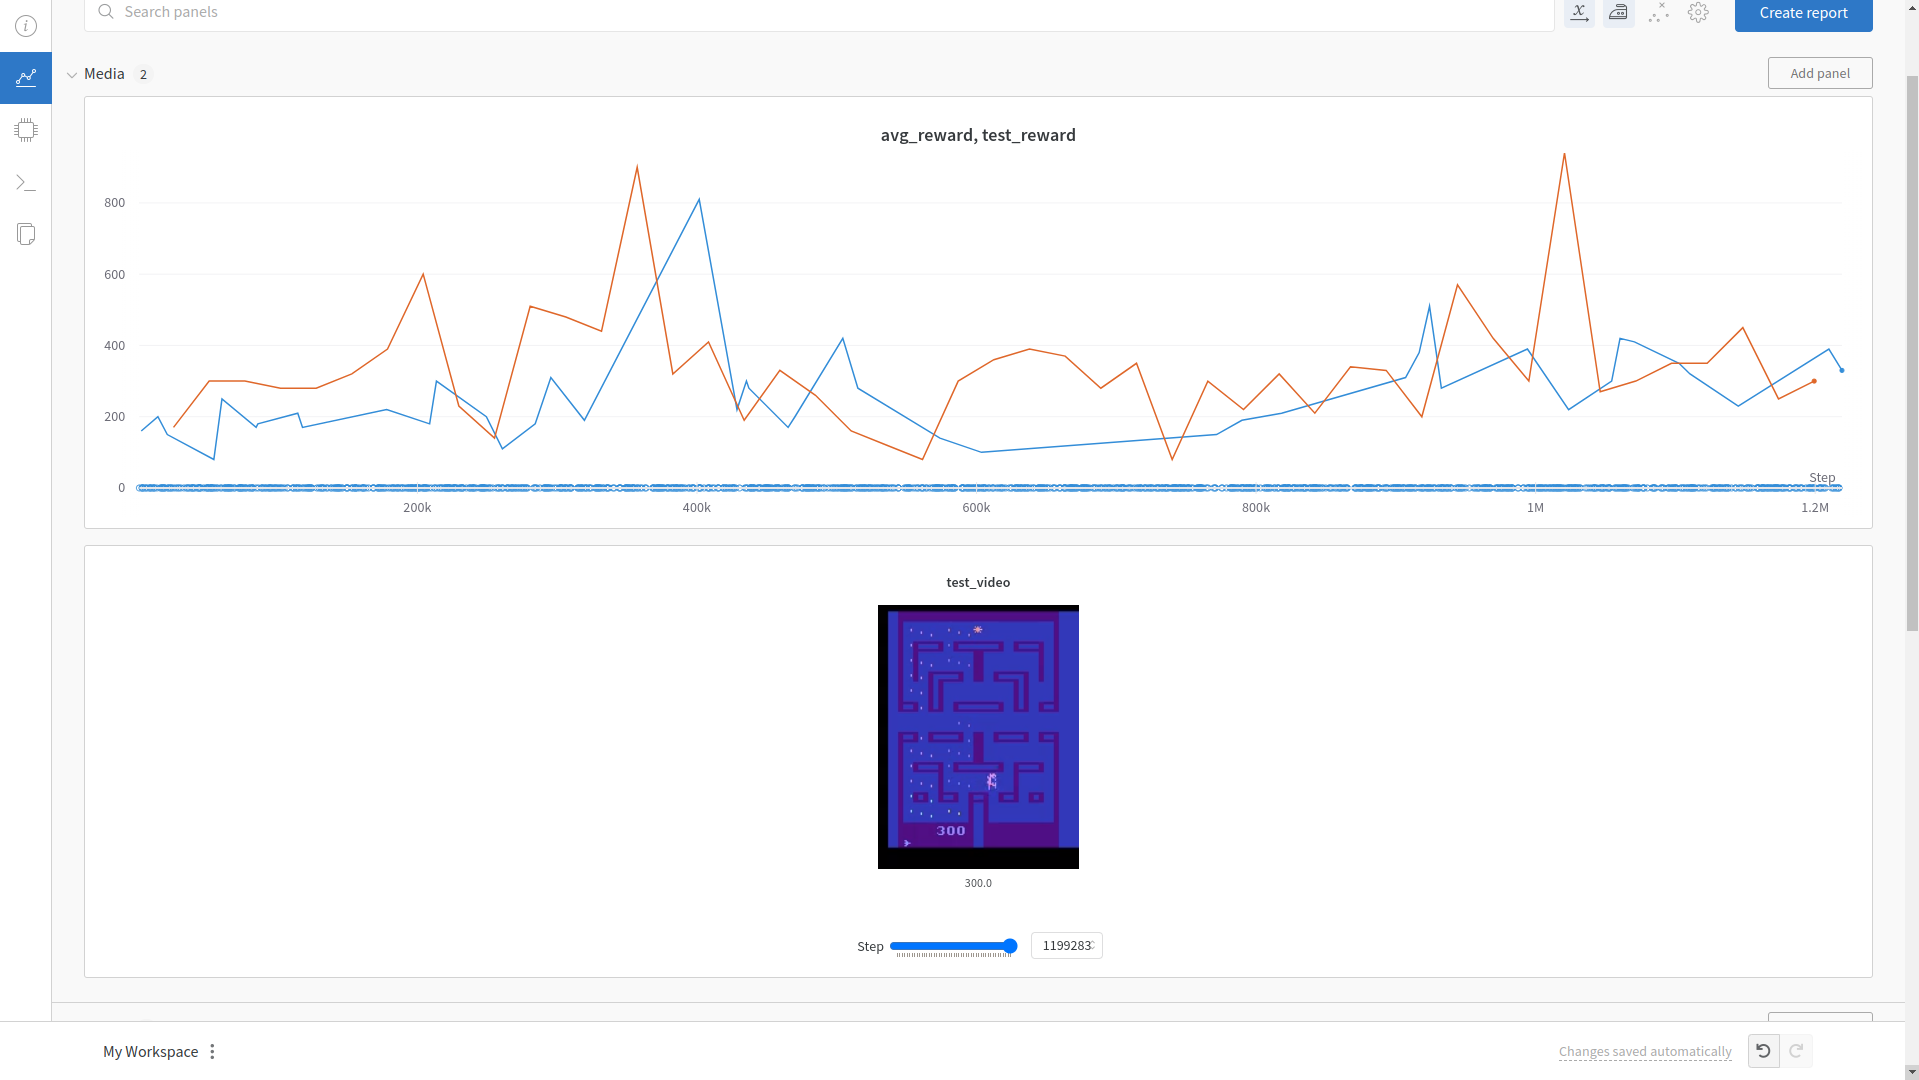